## Unsupervised Learning - Challenge (Credit Card Transactions)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# --------------------------must have---------------------------
import numpy as np
import pandas as pd
import random

# ----------------------plotting libraries----------------------
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from colorsys import hsv_to_rgb
from yellowbrick.cluster import KElbowVisualizer

plt.rcParams["figure.figsize"] = (8, 8)  # Change matplotlib Box Size
plt.rcParams["font.size"] = 14  # Change matplotlib Font Size

from sklearn.manifold import TSNE
import umap


# ----------------------sklearn libraries-----------------------
from sklearn import preprocessing, datasets, decomposition, manifold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
)
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA

# ---------------------------Clustering------------------------------
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score


# ---------------------------others------------------------------
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

import umap
import time

In [4]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 8)

In [5]:
#data = pd.read_csv("..//data/card_transactions.csv")

In [6]:
from pathlib import Path

path = Path("C:/Users/Konstantinos/Desktop")
file1 = path/"card_transactions.csv"
#file2 = path/"PlayerPlayingPositionDat.csv"
data = pd.read_csv(file1,sep=',',dtype=str)
#df_raw = data.copy()

**Features**

The features:
- customer_id : id of the credit card holder
- balance_account : balance amount left in the account to make purchases at the end of the 6-month period

- purchases_amount : amount of purchases made from account
- paid_advance : number of transactions made with “Cash in Advance” method
- full_purchases : maximum purchase amount done in full payment
- balance_frequency_update : how frequently the balance has been updated, score between 0 and 1 (1 = frequently - updated, 0 = not frequently updated)
- installments : amount of purchases done in installments
- purchases_frequency : how frequently the purchases are being made, score between 0 and 1 (1 = frequently - - purchased, 0 = not frequently purchased)
- full_purchases_frequency : how frequently purchases are happening in full payment (1 = frequently purchased, - 0 = not frequently purchased)
- purchases_installments_frequency : how frequently purchases in installments are being done (1 = frequently - done, 0 = not frequently done)
- cash_advance_frequency : how frequently the cash in advance being paid
- nr_cash_advances : cash in advance given by the user
- nr_purchases : number of purchase transactions made
- credit_limit : limit of credit card for user
- fixed_rate_period : duration of fixed interest rate of credit card service for user (in months)
- payments : amount of payment done by user
- min_payments : minimum amount of payments made by user
- full_payment_prc : percent of full payment paid by user

**Task**

find the most useful customer segmentation to improve the marketing campaigns of the company.

In [7]:
data.head(10)

customer_id     balance_account purchases_amount        paid_advance  \
0  tGEg8fT2eCgVxdwS            9.298409            107.6                 0.0   
1  stEDu20sSKOXomjg           52.666422            150.3                 0.0   
2  CEB2blrN3b88GsRe         1360.795674              0.0  462.86144299999995   
3  0N0eBl8ySaZThxKE         2021.641161           363.18                 0.0   
4  6NLauoHUwtwOv4Wy           22.322374             95.0         1162.045833   
5  3Zx75mmL4wXFf36M          9266.08054            100.0         4383.296268   
6  VIncqsQDzbMSsvL9   97.38932700000001             60.0                 0.0   
7  fDoLh1FTtFMuu3xs         4788.283283              0.0  437.80858600000005   
8  OpclyuJ9WGTLImw1          319.037744          1262.28                 0.0   
9  k2GbzBNCo0TQmwaw  1641.2512179999999              0.0  2990.1655379999997   

  full_purchases balance_frequency_update installments purchases_frequency  \
0            0.0                 0.909091        107.6            0.909091   
1            0.0                      1.0        150.3                 1.0   
2            0.0                      1.0          0.0                 0.0   
3         363.18                      1.0          0.0                 1.0   
4           95.0                 0.363636          0.0            0.083333   
5            0.0                      1.0        100.0            0.333333   
6           60.0                      1.0          0.0            0.083333   
7            0.0                      1.0          0.0                 0.0   
8        1262.28                 0.818182          0.0                0.25   
9            0.0                 0.727273          0.0                 0.0   

  full_purchases_frequency purchases_installments_frequency  \
0                      0.0                         0.818182   
1                      0.0                         0.833333   
2                      0.0                              0.0   
3                      1.0                              0.0   
4                 0.083333                              0.0   
5                      0.0                             0.25   
6                 0.083333                              0.0   
7                      0.0                              0.0   
8                     0.25                              0.0   
9                      0.0                              0.0   

  cash_advance_frequency nr_cash_advances nr_purchases credit_limit  \
0                    0.0                0           10       1000.0   
1                    0.0                0            6       1000.0   
2               0.272727                6            0       1500.0   
3                    0.0                0           13       2000.0   
4               0.166667                3            1       2500.0   
5               0.166667                3            4      17500.0   
6                    0.0                0            1      12500.0   
7               0.166667                2            0       5000.0   
8                    0.0                0            6      10500.0   
9               0.166667                4            0       3000.0   

  fixed_rate_period            payments        min_payments  \
0                11           89.868853           89.711672   
1                 6  54.722514000000004            82.95518   
2                11          303.031979          443.781316   
3                12           704.24077          795.859808   
4                12  4094.2614270000004           40.142262   
5                12  2444.1235469999997         2603.406476   
6                12          453.421982           204.88001   
7                12          823.840717         1934.821741   
8                12         1350.541585  218.81061400000002   
9                12         4399.723425  500.27615499999996   

      full_payment_prc  
0             0.428571  
1                  0.0  
2                  0.0 

In [8]:
data.shape

(8500, 18)

In [9]:
data = data.drop("customer_id", axis=1)

In [10]:
data.describe()

balance_account purchases_amount paid_advance full_purchases  \
count             8500             8500         8500           8500   
unique            8425             5896         4097           3826   
top                0.0              0.0          0.0            0.0   
freq                76             1941         4404           4087   

       balance_frequency_update installments purchases_frequency  \
count                      8500         8500                8500   
unique                       43         4240                  47   
top                         1.0          0.0                 1.0   
freq                       5883         3723                2048   

       full_purchases_frequency purchases_installments_frequency  \
count                      8500                             8500   
unique                       47                               47   
top                         0.0                              0.0   
freq                       4087                             3722   

       cash_advance_frequency nr_cash_advances nr_purchases credit_limit  \
count                    8500             8500         8500         8499   
unique                     54               63          172          203   
top                       0.0                0            0       3000.0   
freq                     4404             4404         1941          755   

       fixed_rate_period payments min_payments full_payment_prc  
count               8500     8500         8202             8500  
unique                 7     8274         8201               47  
top                   12      0.0   299.351881              0.0  
freq                7195      227            2             5626

In [11]:
data.isna().sum()

balance_account                       0
purchases_amount                      0
paid_advance                          0
full_purchases                        0
balance_frequency_update              0
installments                          0
purchases_frequency                   0
full_purchases_frequency              0
purchases_installments_frequency      0
cash_advance_frequency                0
nr_cash_advances                      0
nr_purchases                          0
credit_limit                          1
fixed_rate_period                     0
payments                              0
min_payments                        298
full_payment_prc                      0
dtype: int64

In [12]:
data["credit_limit"].fillna(data["credit_limit"].median(), inplace=True)
data["min_payments"].fillna(data["min_payments"].median(), inplace=True)

In [13]:
data.isna().sum()

balance_account                     0
purchases_amount                    0
paid_advance                        0
full_purchases                      0
balance_frequency_update            0
installments                        0
purchases_frequency                 0
full_purchases_frequency            0
purchases_installments_frequency    0
cash_advance_frequency              0
nr_cash_advances                    0
nr_purchases                        0
credit_limit                        0
fixed_rate_period                   0
payments                            0
min_payments                        0
full_payment_prc                    0
dtype: int64

In [14]:
#new
data = data.applymap(lambda x: eval(x) if type(x) == str else x)

**New features**

In [15]:
#Shows level of debt
data['outstanding'] = data.credit_limit + data.payments - data.balance_account
data['outstanding']

0       1080.570444
1       1002.056092
2        442.236305
3        682.599609
4       6571.939053
           ...     
8495    8034.779725
8496    1620.565077
8497    2937.932505
8498    1816.463602
8499    2376.854185
Name: outstanding, Length: 8500, dtype: float64

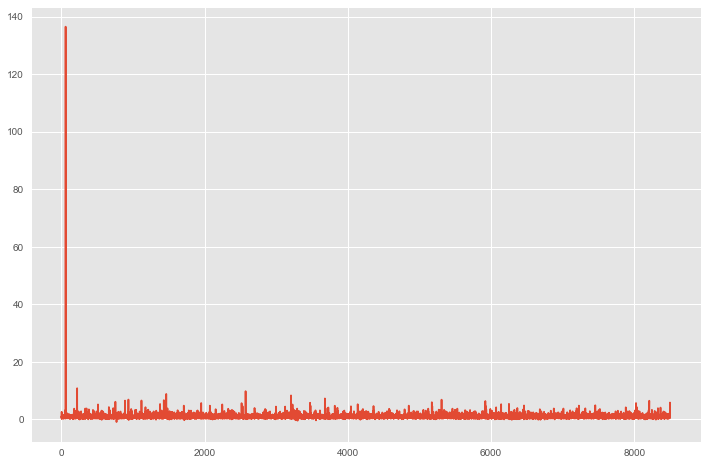

In [16]:
#Shows level of debt
data['Used_line'] = data['outstanding']/data['credit_limit']
data['Used_line'].plot()
data = data[data['Used_line'] <20]

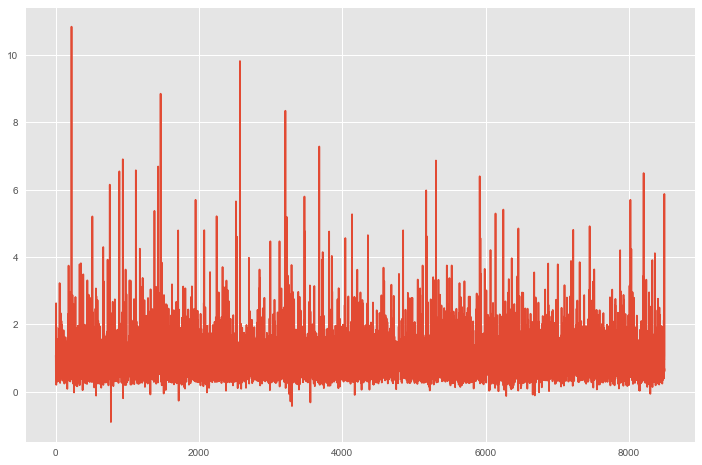

In [17]:
data['Used_line'].plot()


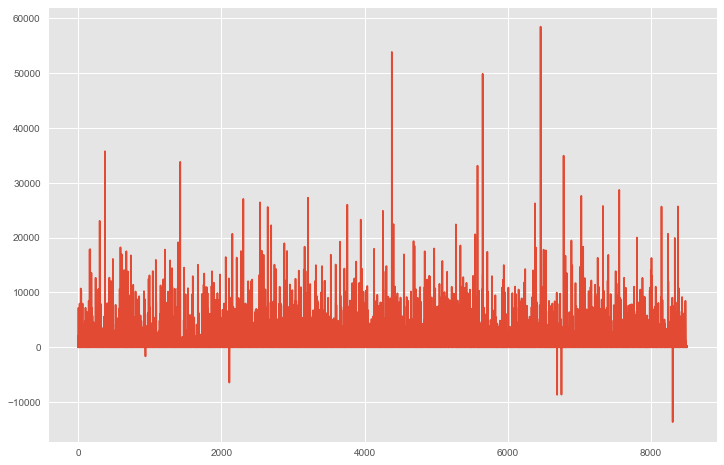

In [18]:
#Shows usage of card for cash, credit or both
data['cash_to_credit_ratio'] = data['paid_advance']/data['Used_line']
data = data[data['cash_to_credit_ratio'] <75000]
data['cash_to_credit_ratio'].plot()


**Features not really required**

In [19]:
data = data.drop(['paid_advance','full_purchases','installments','fixed_rate_period','min_payments','payments','nr_cash_advances','nr_purchases'],1)

## Histogram of features 

In [20]:
#new
def plot_distrib(df, ncols, nrows, figsize):
    vars_ = df.columns
    c = 0
    plt.figure(figsize=figsize)
    for v in vars_:
        ax = plt.subplot(nrows, ncols, c + 1)
        _, nbins, _ = plt.hist(df[v], 50, color="g", alpha=0.6, label=v)
        plt.xlabel(v)
        plt.legend(loc="best")
        c = c + 1
    plt.show()

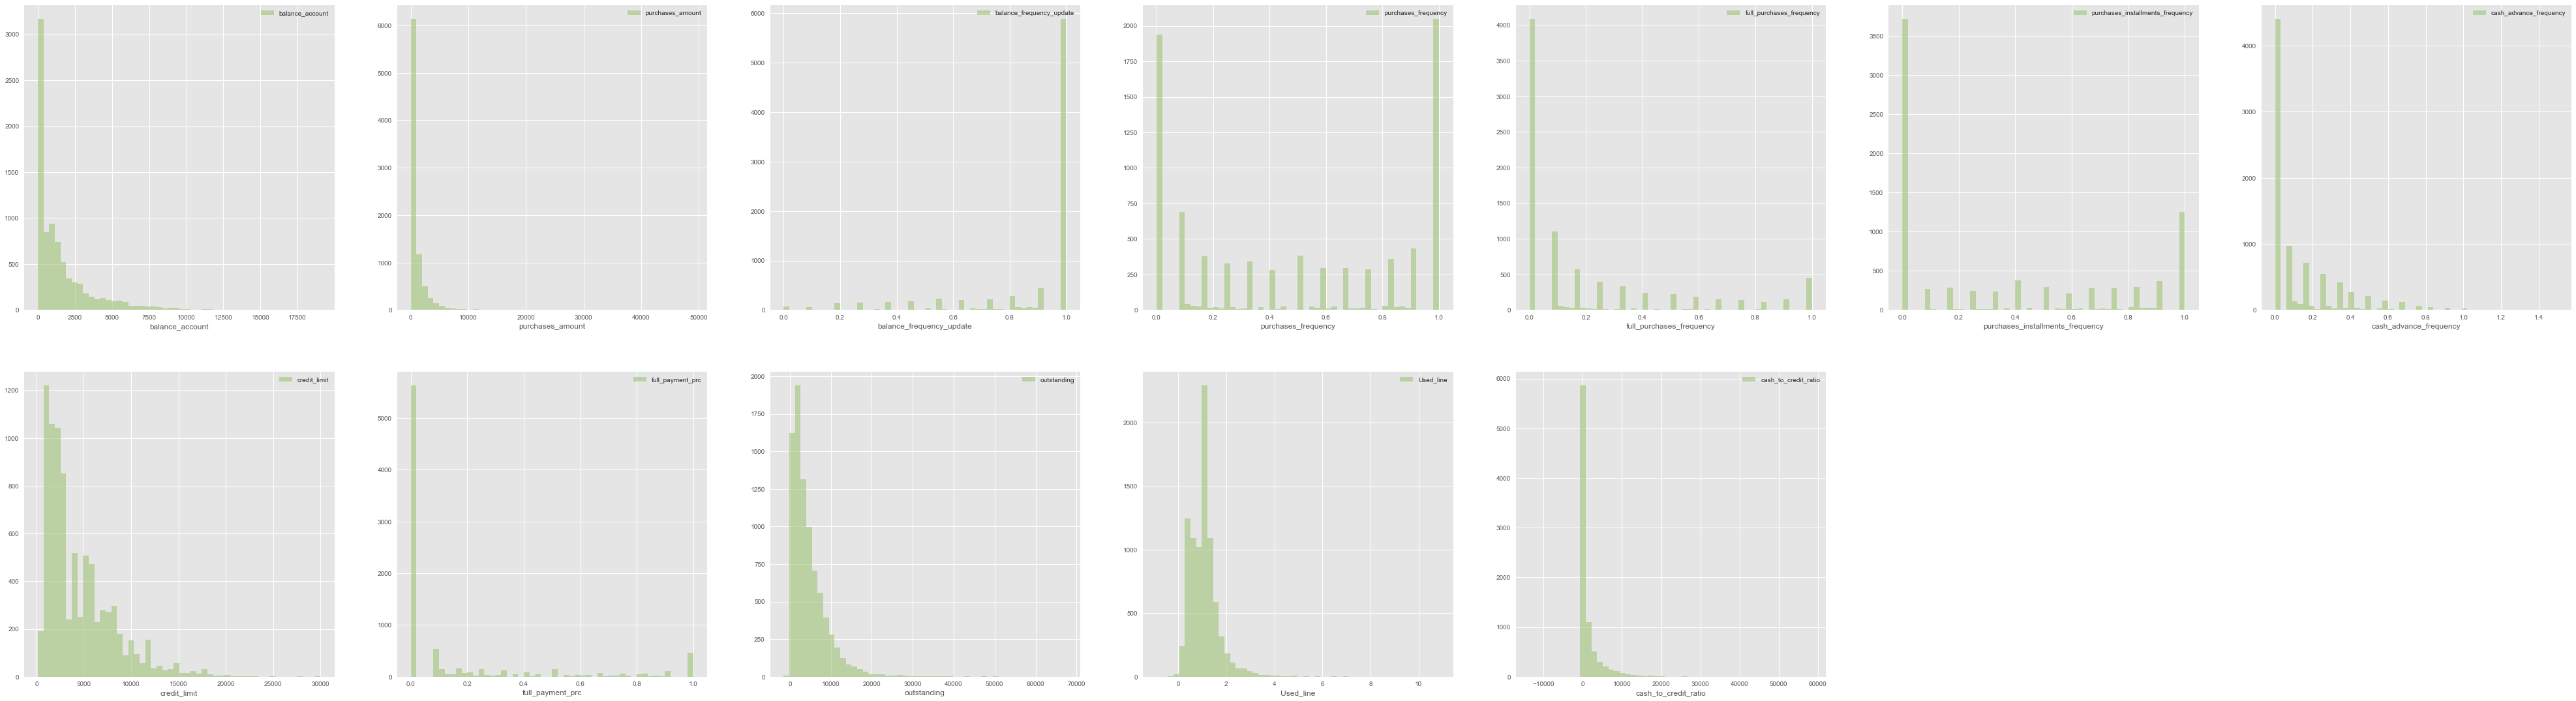

In [21]:
plot_distrib(data, ncols=7, nrows=5, figsize=(70, 50))

## boxplot of features

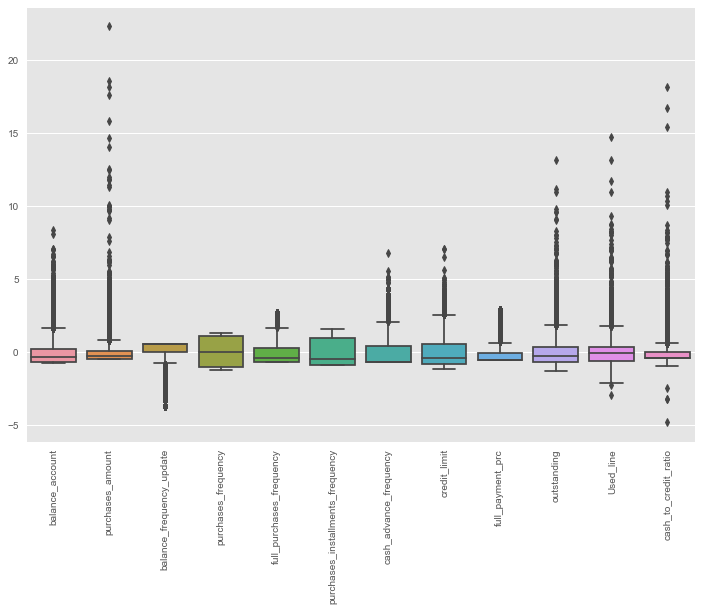

In [22]:
# scale data
scaler = StandardScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
ax = sns.boxplot(data=data_scaled)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

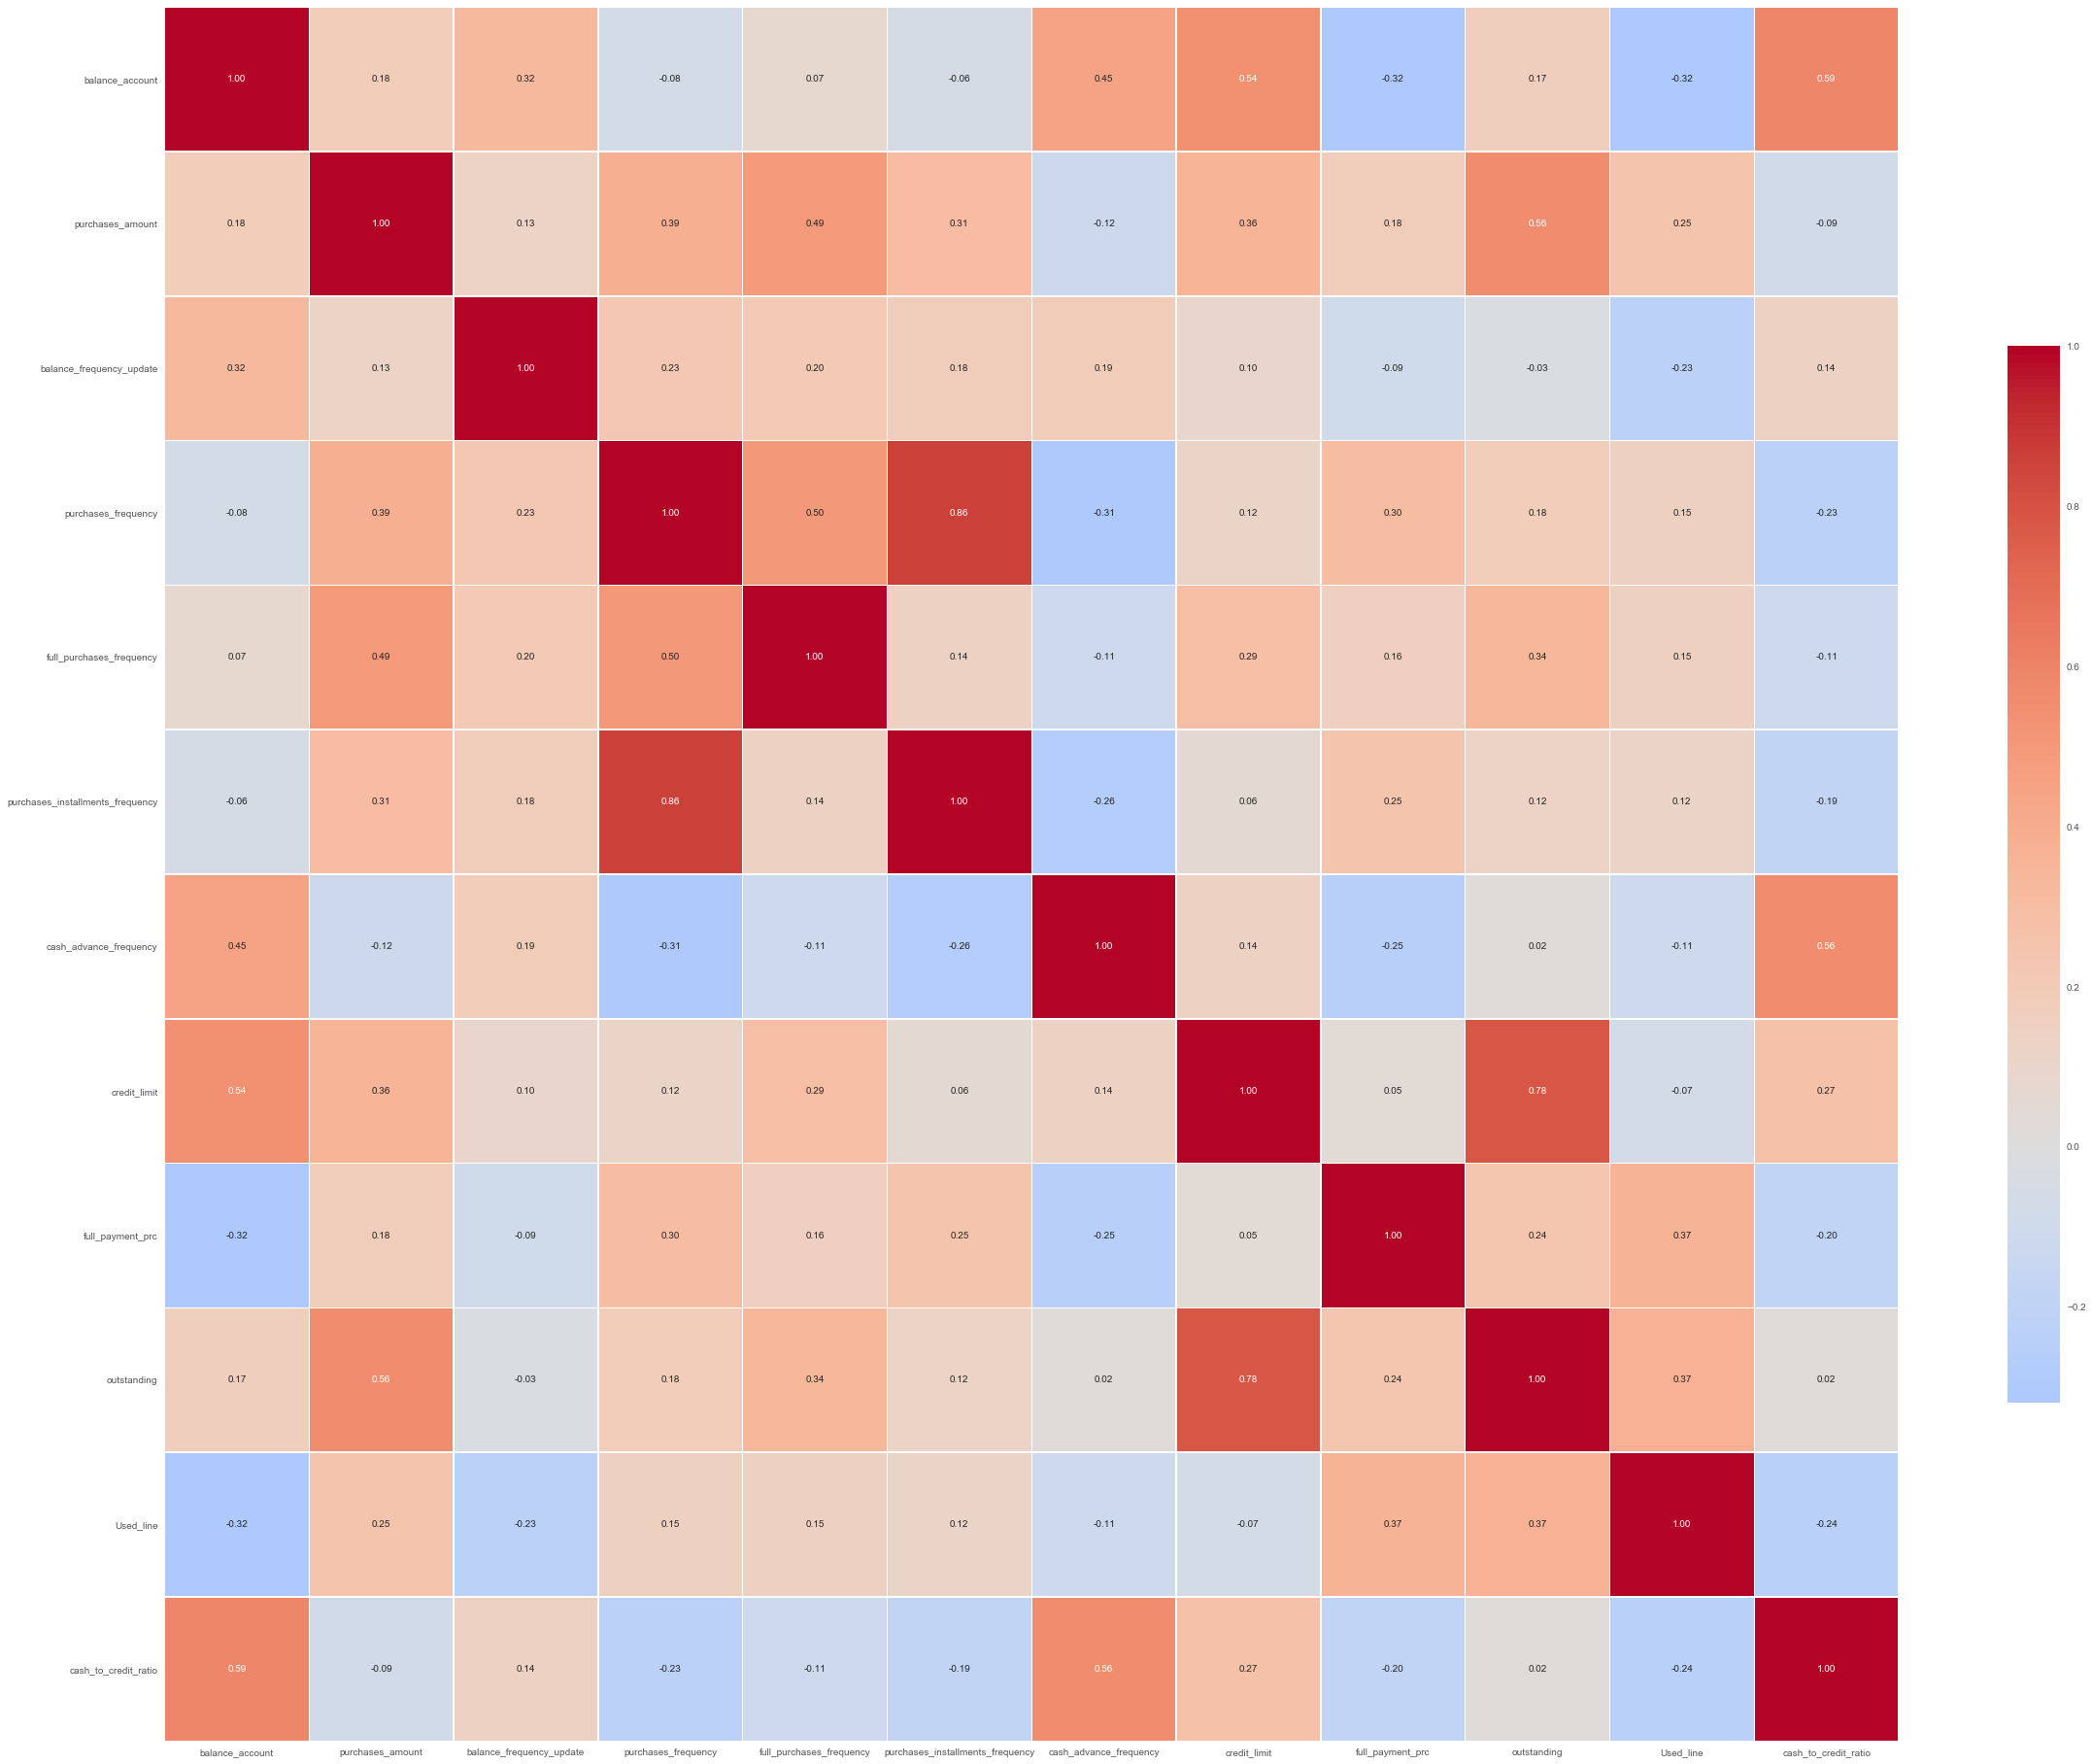

In [23]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(40, 40))
h = sns.heatmap(
    corr,
    cmap="coolwarm",
    vmax=1,
    fmt=".2f",
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

In [24]:
to_keep = [data.columns[0]]
for icol in range(1, len(data.corr().index)):
    if np.any((data.corr() > 0.85).iloc[: icol - 1, icol]):
        print(f"{data.corr().index[icol]} is out")
    else:
        to_keep.append(data.corr().index[icol])
print(to_keep)

purchases_installments_frequency is out
['balance_account', 'purchases_amount', 'balance_frequency_update', 'purchases_frequency', 'full_purchases_frequency', 'cash_advance_frequency', 'credit_limit', 'full_payment_prc', 'outstanding', 'Used_line', 'cash_to_credit_ratio']


In [25]:
data_filtered = data.drop(
    ["purchases_installments_frequency"], axis=1
)
data_filtered.head()

balance_account  purchases_amount  balance_frequency_update  \
0         9.298409            107.60                  0.909091   
1        52.666422            150.30                  1.000000   
2      1360.795674              0.00                  1.000000   
3      2021.641161            363.18                  1.000000   
4        22.322374             95.00                  0.363636   

   purchases_frequency  full_purchases_frequency  cash_advance_frequency  \
0             0.909091                  0.000000                0.000000   
1             1.000000                  0.000000                0.000000   
2             0.000000                  0.000000                0.272727   
3             1.000000                  1.000000                0.000000   
4             0.083333                  0.083333                0.166667   

   credit_limit  full_payment_prc  outstanding  Used_line  \
0        1000.0          0.428571  1080.570444   1.080570   
1        1000.0          0.000000  1002.056092   1.002056   
2        1500.0          0.000000   442.236305   0.294824   
3        2000.0          0.000000   682.599609   0.341300   
4        2500.0          0.000000  6571.939053   2.628776   

   cash_to_credit_ratio  
0              0.000000  
1              0.000000  
2           1569.957411  
3              0.000000  
4            442.048315

In [26]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8497 entries, 0 to 8499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   balance_account           8497 non-null   float64
 1   purchases_amount          8497 non-null   float64
 2   balance_frequency_update  8497 non-null   float64
 3   purchases_frequency       8497 non-null   float64
 4   full_purchases_frequency  8497 non-null   float64
 5   cash_advance_frequency    8497 non-null   float64
 6   credit_limit              8497 non-null   float64
 7   full_payment_prc          8497 non-null   float64
 8   outstanding               8497 non-null   float64
 9   Used_line                 8497 non-null   float64
 10  cash_to_credit_ratio      8497 non-null   float64
dtypes: float64(11)
memory usage: 796.6 KB


In [27]:
# automated version incl. scaler, but returns an array

# X = pd.DataFrame(StandardScaler().fit_transform(data[to_keep]))
# X

In [28]:
scaler = StandardScaler()

data_scaled = pd.DataFrame(
    scaler.fit_transform(data_filtered), columns=data_filtered.columns
)
data_scaled

balance_account  purchases_amount  balance_frequency_update  \
0           -0.744699         -0.414094                  0.138303   
1           -0.723933         -0.394274                  0.521017   
2           -0.097562         -0.464039                  0.521017   
3            0.218870         -0.295461                  0.521017   
4           -0.738463         -0.419943                 -2.157989   
...               ...               ...                       ...   
8492        -0.209219         -0.464039                  0.521017   
8493        -0.738900         -0.394548                  0.521017   
8494        -0.749151         -0.464039                 -3.688847   
8495         0.039186          0.022106                  0.521017   
8496         0.141992          0.349217                  0.521017   

      purchases_frequency  full_purchases_frequency  cash_advance_frequency  \
0                1.046234                 -0.678244               -0.673230   
1                1.272910                 -0.678244               -0.673230   
2               -1.220533                 -0.678244                0.684539   
3                1.272910                  2.680195               -0.673230   
4               -1.012747                 -0.398375                0.156520   
...                   ...                       ...                     ...   
8492            -1.220533                 -0.678244               -0.258358   
8493             1.065124                 -0.678244               -0.673230   
8494            -1.220533                 -0.678244               -0.120065   
8495             0.233975                  1.280844                0.156520   
8496             1.065124                  1.280844               -0.673230   

      credit_limit  full_payment_prc  outstanding  Used_line  \
0        -0.960341          0.946724    -0.746876   0.011250   
1        -0.960341         -0.523437    -0.763343  -0.106895   
2        -0.822574         -0.523437    -0.880752  -1.171114   
3        -0.684806         -0.523437    -0.830341  -1.101179   
4        -0.547039         -0.523437     0.404812   2.340938   
...            ...               ...          ...        ...   
8492      1.106172         -0.523437     0.711609  -0.192348   
8493     -0.822574          0.048294    -0.633625   0.010959   
8494     -1.098109         -0.523437    -0.357337   7.227050   
8495     -0.409271         -0.523437    -0.592539  -0.703638   
8496     -0.271504         -0.523437    -0.475010  -0.592867   

      cash_to_credit_ratio  
0                -0.438445  
1                -0.438445  
2                 0.060692  
3                -0.438445  
4                -0.297904  
...                    ...  
8492             -0.347266  
8493             -0.438445  
8494             -0.424708  
8495             -0.361442  
8496             -0.438445  

[8497 rows x 11 columns]

#### K-means clustering

#### Elbow

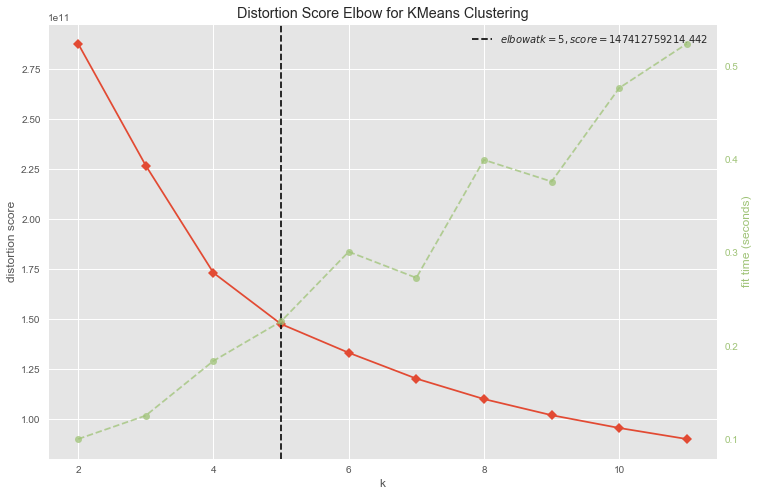

In [29]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(data_filtered)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

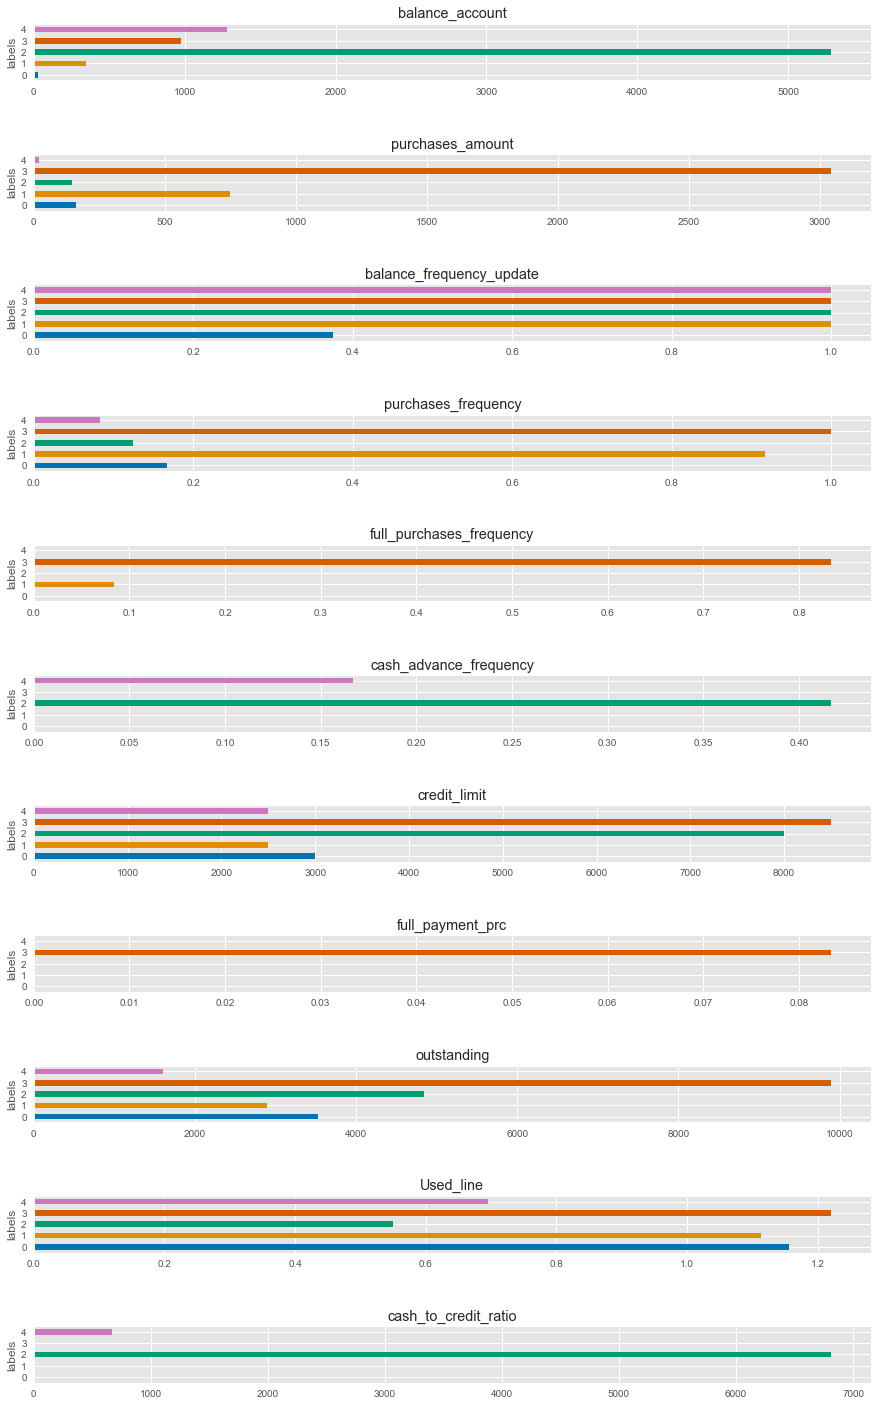

In [68]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(data_scaled)

data["labels"] = kmeans.labels_

data_group = data[to_keep + ["labels"]].groupby("labels").median()

fig, ax = plt.subplots(len(to_keep), 1, figsize=(15, 25))
plt.subplots_adjust(wspace=0.7, hspace=1.3)
for icat, cat in enumerate(to_keep):
    data_group[cat].plot.barh(ax=ax[icat], color=sns.color_palette("colorblind", 5))
    ax[icat].set_title(cat)

In [98]:
#data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
#data_group = data[to_keep + ["labels"]].groupby("labels")
#data_group = data[to_keep + ["labels"]].groupby("labels").boxplot( sharex=True,vert=False)
#sns.violinplot( data= data_group,x=to_keep, y= 'labels', hue='labels')
#ax = sns.boxplot(data=data_scaled)
#plt.setp(ax.get_xticklabels(), rotation=90)
#plt.show()

In [90]:
import plotly.express as px

fig = px.scatter_3d(data, x=data['purchases_frequency'], y= data['balance_account'], z=data['cash_advance_frequency'], color=data['labels']) 

fig.show()

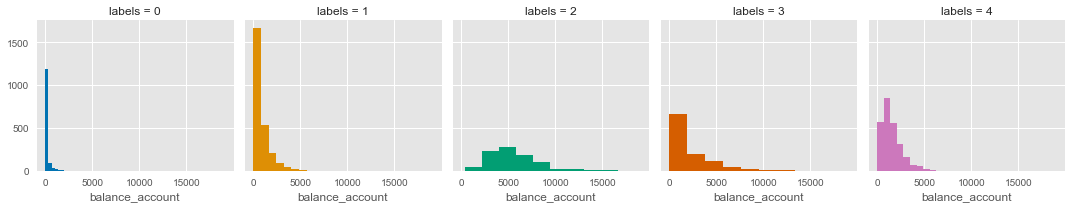

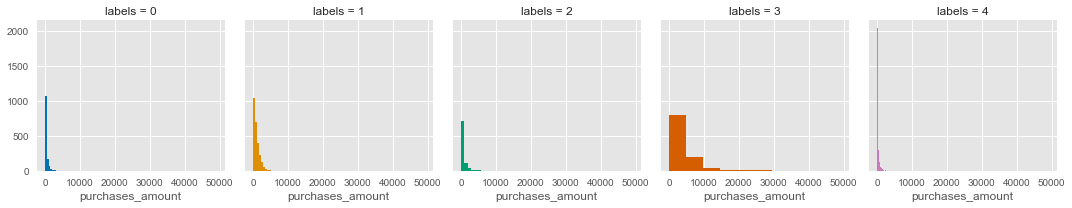

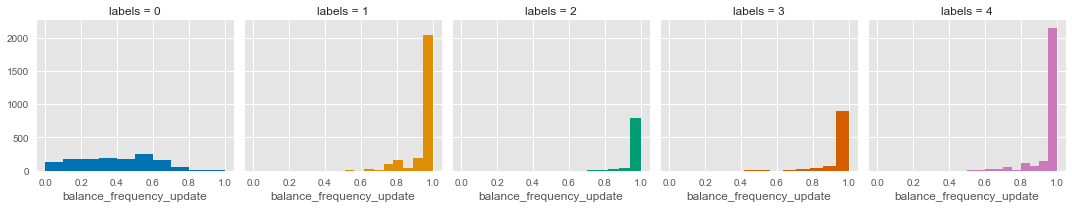

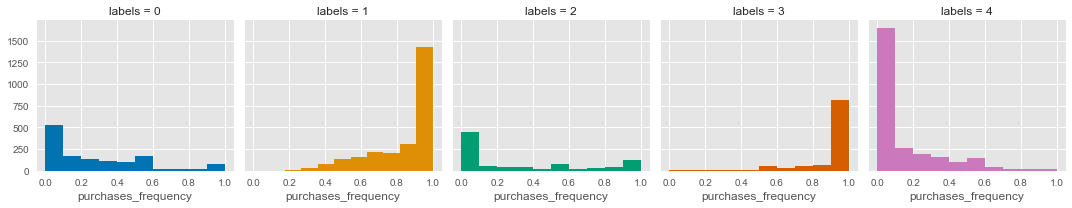

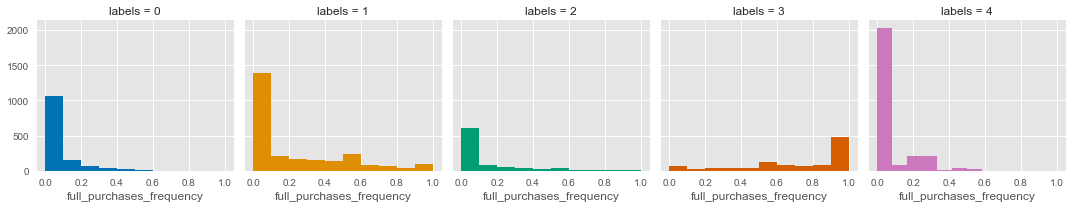

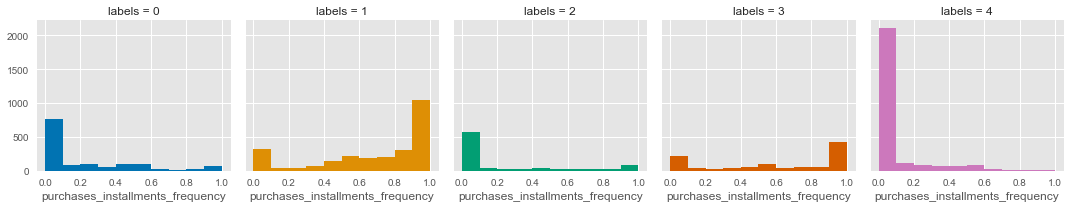

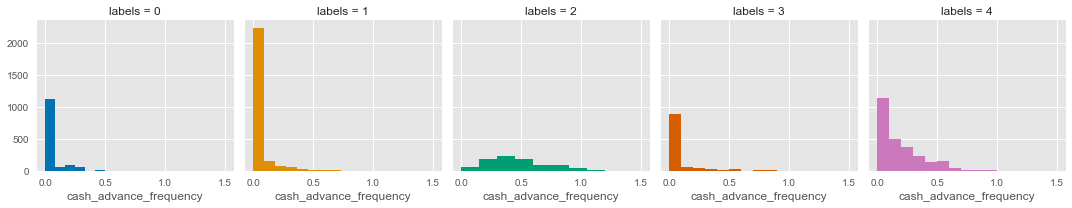

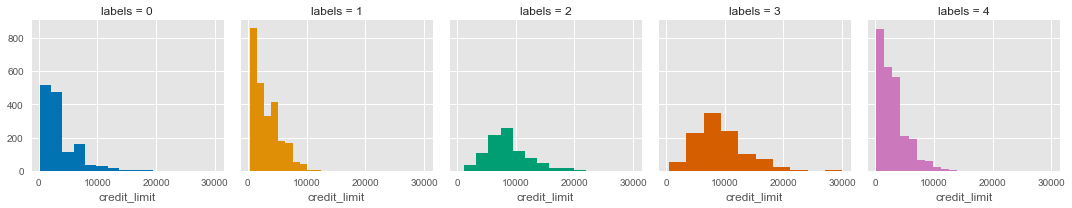

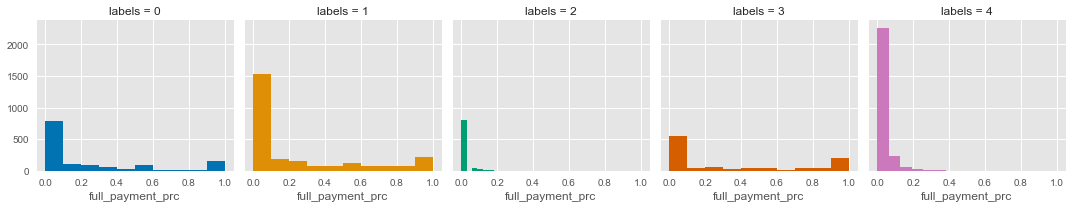

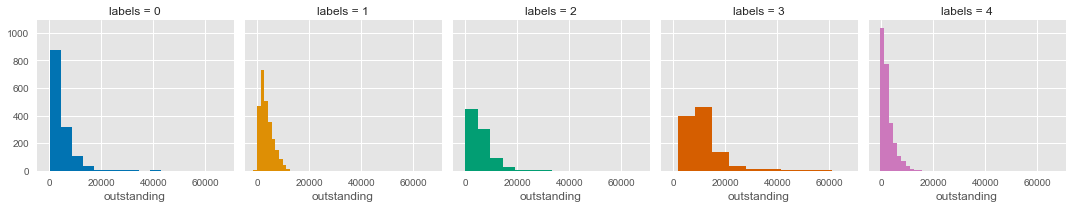

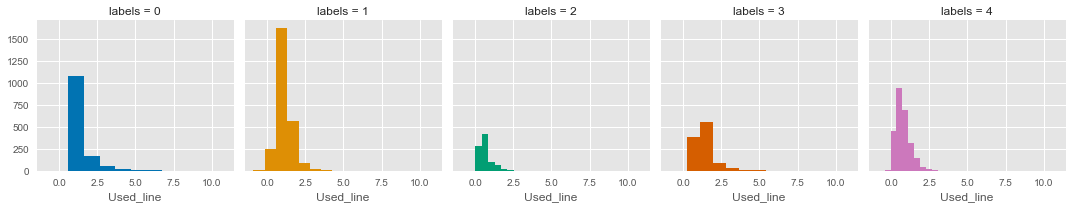

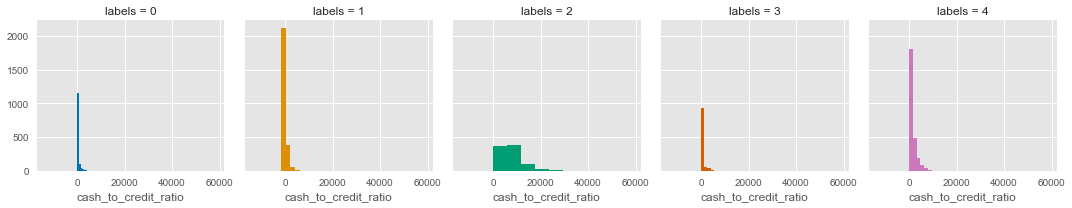

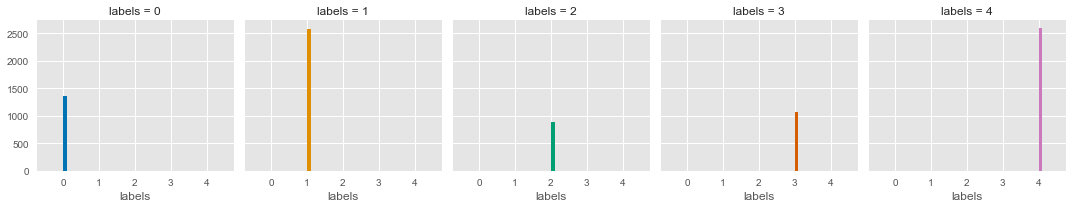

In [97]:
for c in data:
    grid= sns.FacetGrid(data, col='labels',hue='labels',palette=sns.color_palette("colorblind", 5))
    grid.map(plt.hist, c)

In [ ]:
data_group = data[to_keep + ["labels"]].groupby("labels").mean()


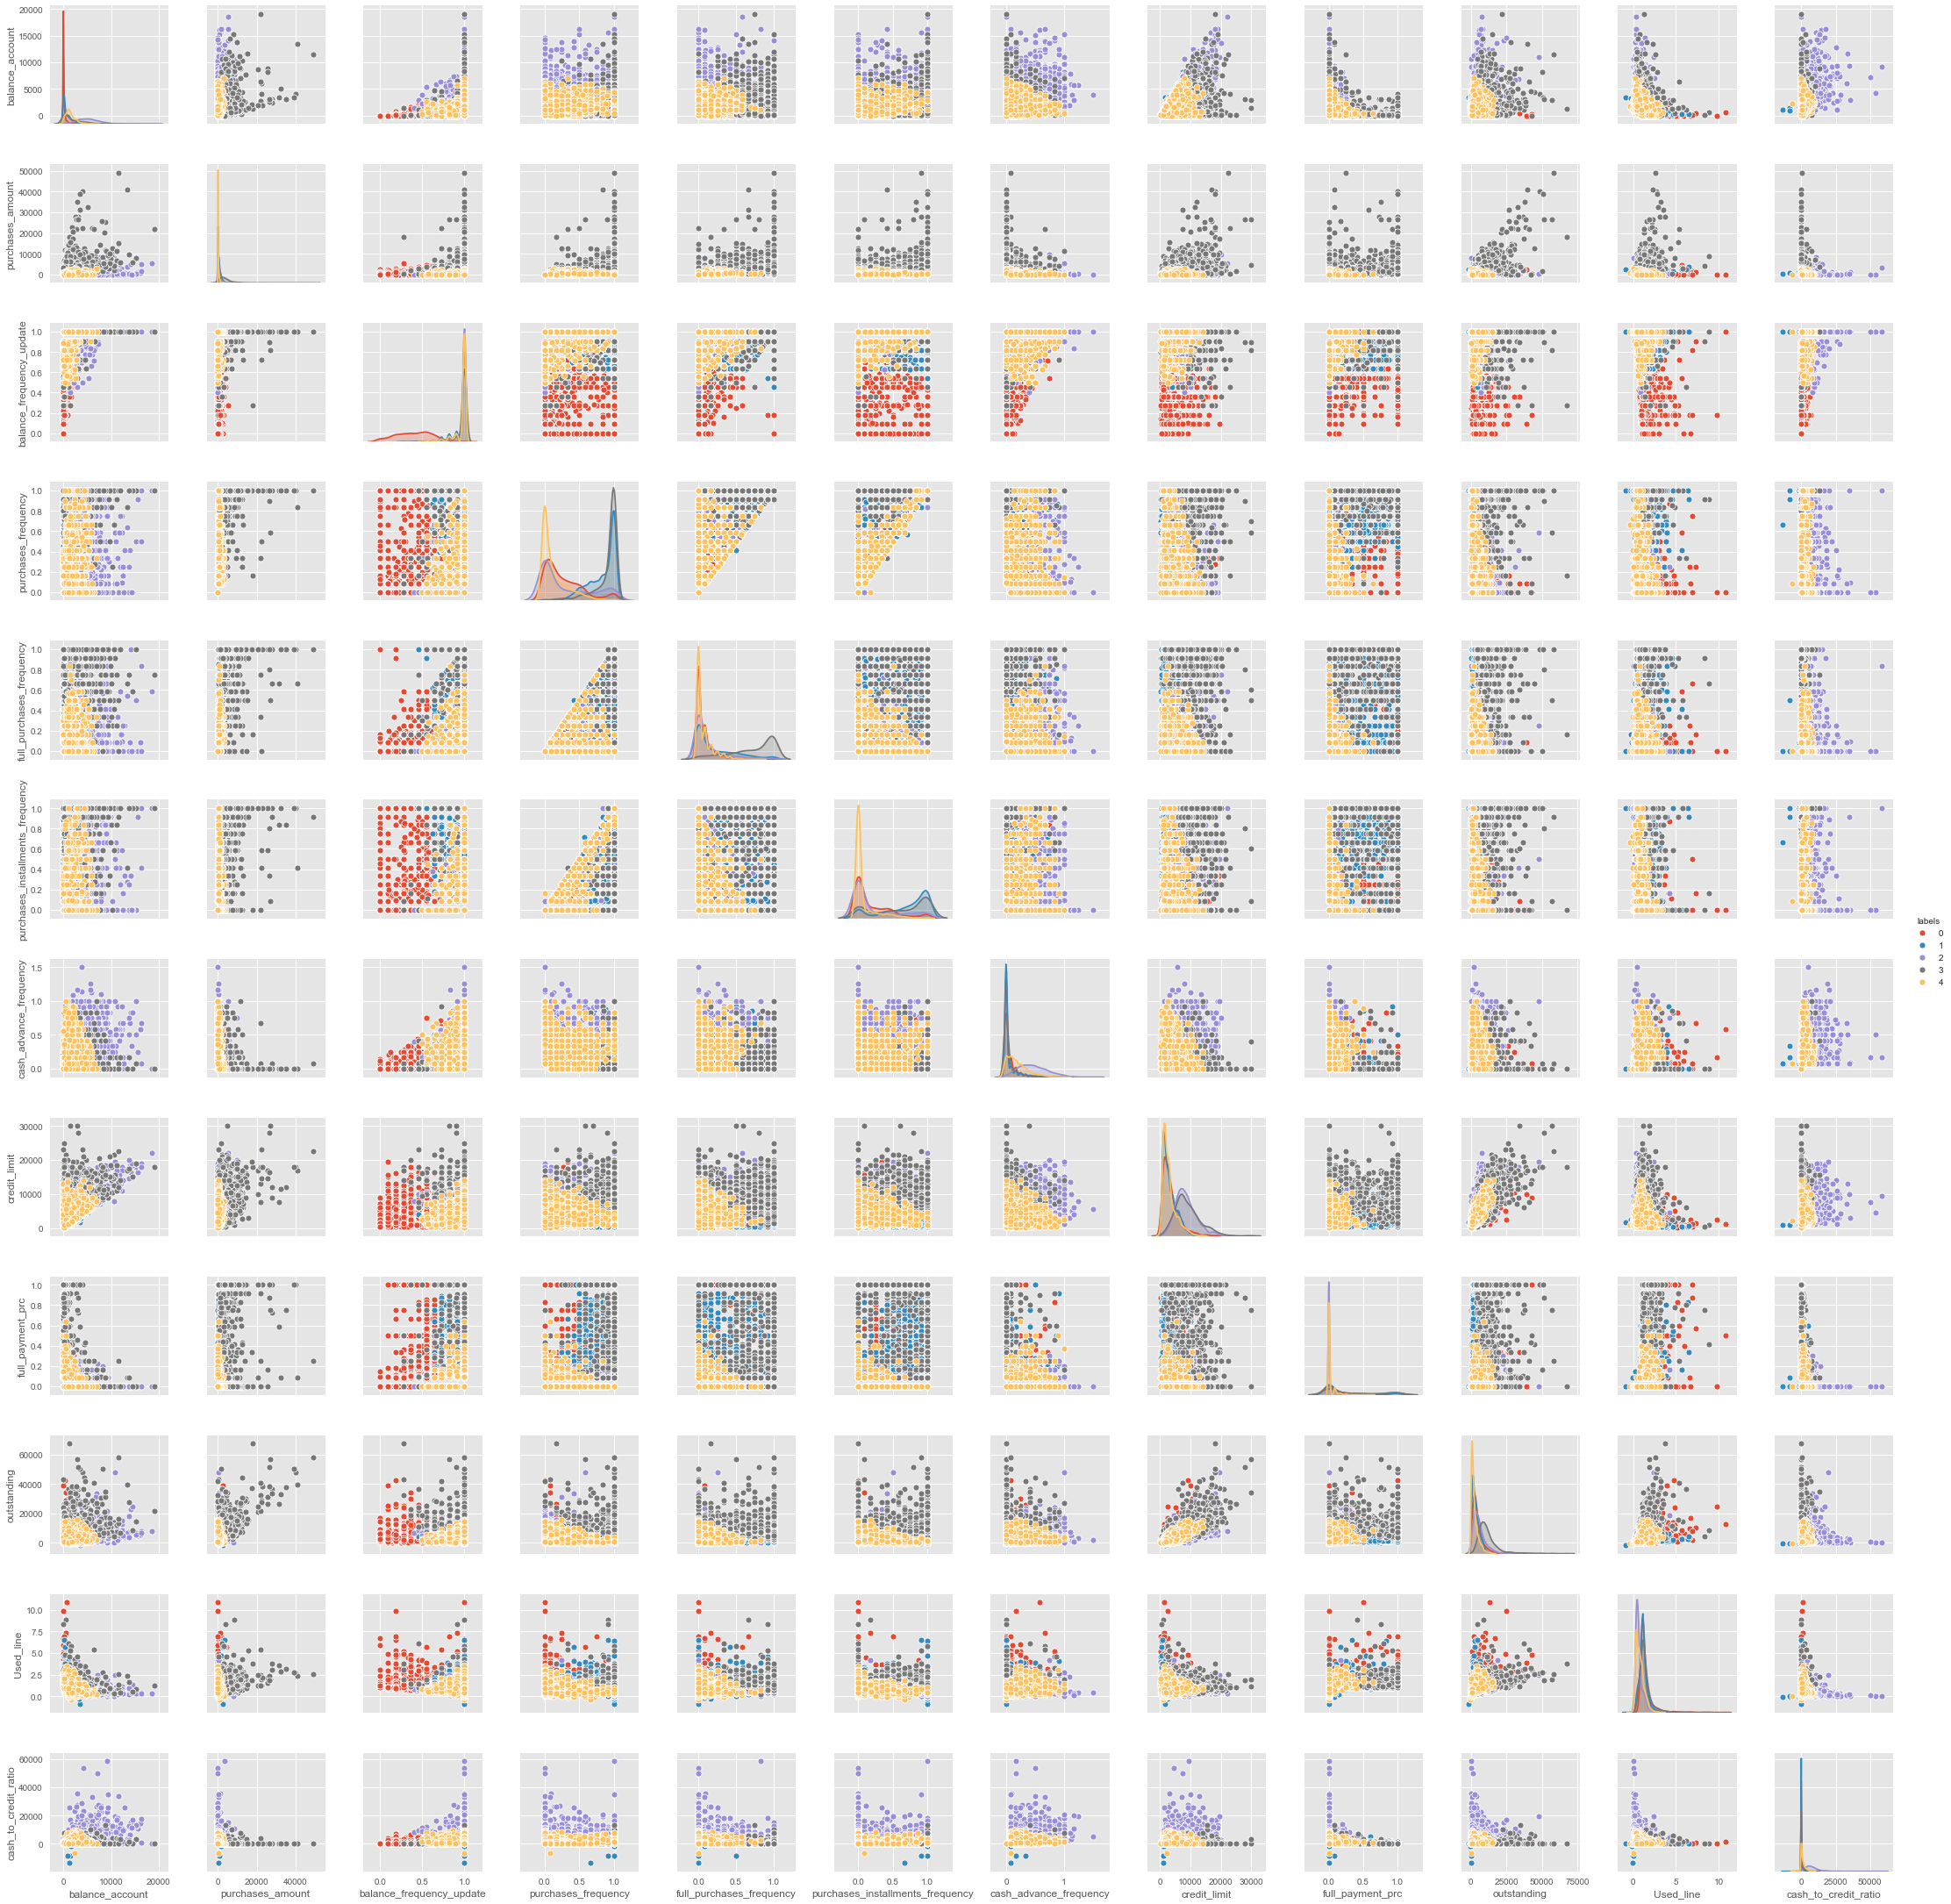

In [31]:
sns.pairplot(data,hue='labels')

In [32]:
import plotly.express as px

fig = px.scatter_3d(data, x=data['purchases_amount'], y= data['credit_limit'], z=data['purchases_frequency'], color=data['labels']) 

fig.show()

#### PCA

In [33]:
pca = PCA()

In [34]:
pipe_pca = Pipeline([("scl", StandardScaler()), ("pca", pca)])

In [35]:
data_pca = pd.DataFrame(pipe_pca.fit_transform(data_scaled))

In [36]:
data_pca

0         1         2         3         4         5         6  \
0    -0.257199 -1.727061 -0.761527  0.556682 -0.923397 -0.034583  0.480405   
1    -0.591578 -1.284064 -1.354322  0.048775  0.008122 -0.193991  0.394155   
2    -2.139790  0.300383 -0.460302  0.027953  0.131455 -0.519806 -0.042255   
3     0.604972 -0.255471 -2.765613 -0.425227  0.379989  1.498454 -1.115043   
4    -0.349558 -1.502906  2.677099  0.254392  1.560817  0.517613 -0.170537   
...        ...       ...       ...       ...       ...       ...       ...   
8492 -0.345097  0.506385  0.731990 -0.976863 -0.113662 -1.466003 -0.600124   
8493 -0.376834 -1.352991 -1.052969  0.250696 -0.345666 -0.320954  0.359576   
8494  0.208019 -3.504580  5.124485  2.146360  3.595522  1.110977  0.635074   
8495 -0.057372  0.114152 -1.463982 -0.100829  0.566645  0.448017 -0.647841   
8496  0.674948 -0.184088 -1.869125 -0.488526  0.376635  0.583993 -0.164875   

             7         8         9        10  
0    -0.450074 -0.299552  0.018021  0.076062  
1    -1.090027 -0.299220  0.399338  0.039621  
2     0.859851 -0.244783  0.188318  0.102794  
3     0.343323  0.436120 -0.301876  0.455980  
4    -0.604702  0.334992 -0.264019  0.007934  
...        ...       ...       ...       ...  
8492  0.004183  0.413393  0.263308 -0.283809  
8493 -0.821932 -0.200766  0.285469  0.017148  
8494 -2.271316  1.840024 -1.710115 -1.067442  
8495  0.531947 -0.015408 -0.110065  0.071213  
8496 -0.017516  0.116894 -0.081464  0.080628  

[8497 rows x 11 columns]

#### How many principal components represent 80% of total variance?

In [37]:
# evr = explained variance ratio
evr = np.cumsum(pipe_pca.named_steps["pca"].explained_variance_ratio_)
evr

array([0.26692278, 0.51652534, 0.64407953, 0.72674356, 0.79474993,
       0.8497321 , 0.89465037, 0.93484711, 0.96768179, 0.99479359,
       1.        ])

In [38]:
x_intercept = np.argmax(evr > 0.8)
x_intercept

5

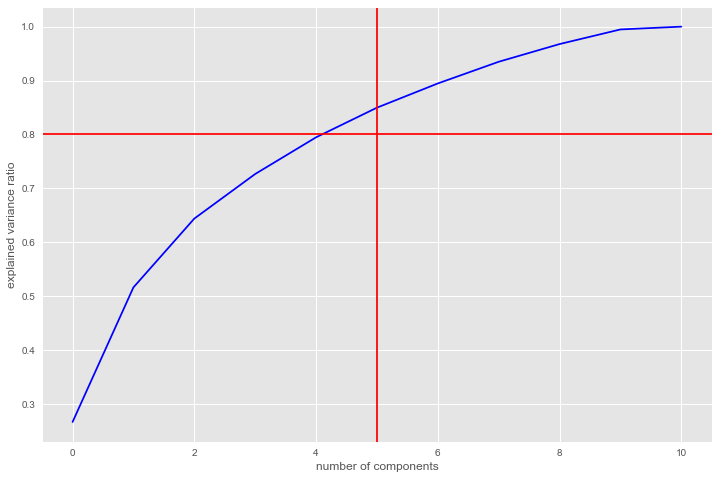

In [39]:
plt.plot(evr, "-x", color="blue")
plt.xlabel("number of components")
plt.ylabel("explained variance ratio")
plt.axvline(x=x_intercept, color="red")
plt.axhline(y=0.80, color="red")
None

From the plot we can see that 80% of the data can be explained by 6 features

#### Alternatively

In [40]:
pipe_pca.set_params(pca__n_components=0.8)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.8,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [41]:
np.cumsum(pipe_pca.named_steps["pca"].explained_variance_ratio_)

array([0.26692278, 0.51652534, 0.64407953, 0.72674356, 0.79474993,
       0.8497321 , 0.89465037, 0.93484711, 0.96768179, 0.99479359,
       1.        ])

In [42]:
data_pca = pd.DataFrame(
    pipe_pca.fit_transform(data_filtered)
)  # new data_pca dataframe with 80% variance
data_pca

0         1         2         3         4         5
0    -0.257199 -1.727061 -0.761527  0.556682 -0.923397 -0.034583
1    -0.591578 -1.284064 -1.354322  0.048775  0.008122 -0.193991
2    -2.139790  0.300383 -0.460302  0.027953  0.131455 -0.519806
3     0.604972 -0.255471 -2.765613 -0.425227  0.379989  1.498454
4    -0.349558 -1.502906  2.677099  0.254392  1.560817  0.517613
...        ...       ...       ...       ...       ...       ...
8492 -0.345097  0.506385  0.731990 -0.976863 -0.113662 -1.466003
8493 -0.376834 -1.352991 -1.052969  0.250696 -0.345666 -0.320954
8494  0.208019 -3.504580  5.124485  2.146360  3.595522  1.110977
8495 -0.057372  0.114152 -1.463982 -0.100829  0.566645  0.448017
8496  0.674948 -0.184088 -1.869125 -0.488526  0.376635  0.583993

[8497 rows x 6 columns]

### Find what each PCA component consists of

In [43]:
pca_80 = pipe_pca.named_steps["pca"]

#### PC1

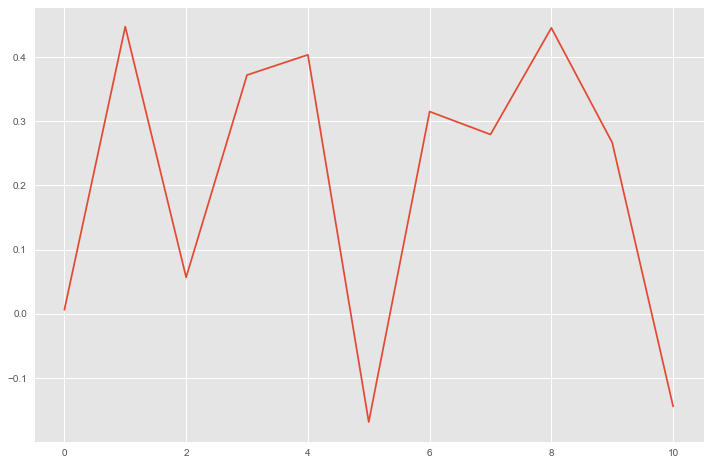

In [44]:
plt.plot(pca_80.components_[0])
None

In [45]:
data_filtered.columns[pca_80.components_[0] > 0.2]

Index(['purchases_amount', 'purchases_frequency', 'full_purchases_frequency',
       'credit_limit', 'full_payment_prc', 'outstanding', 'Used_line'],
      dtype='object')

#### PC2

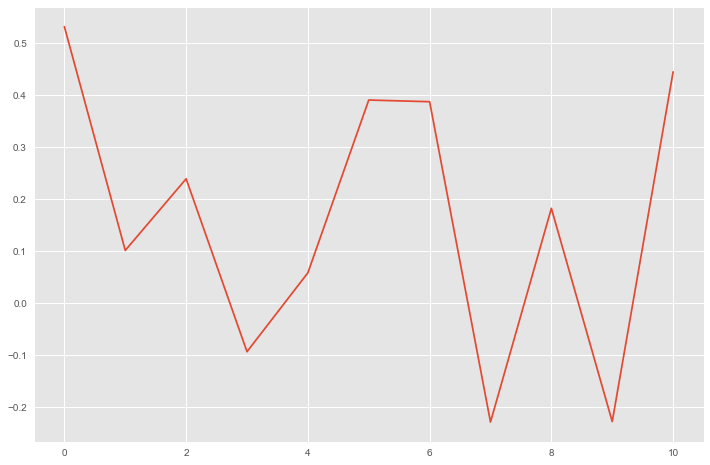

In [46]:
plt.plot(pca_80.components_[1])
None

In [47]:
data_filtered.columns[pca_80.components_[1] > 0.2]

Index(['balance_account', 'balance_frequency_update', 'cash_advance_frequency',
       'credit_limit', 'cash_to_credit_ratio'],
      dtype='object')

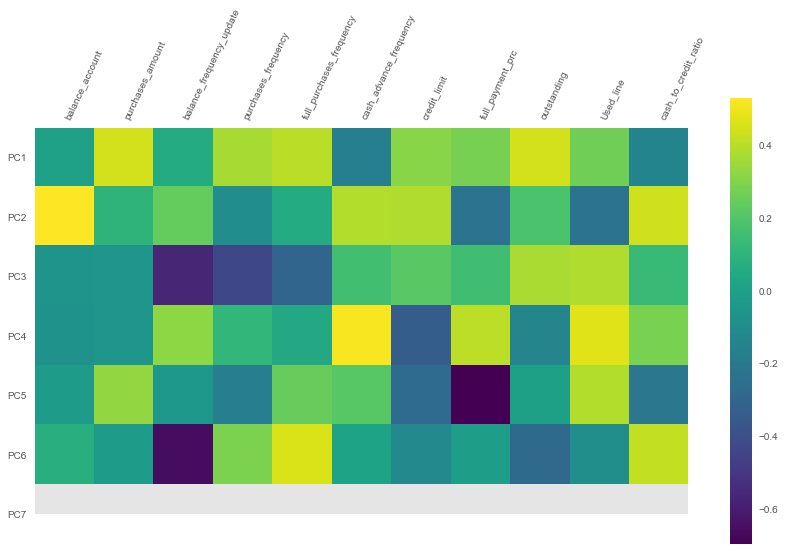

In [48]:
# manual, low skill version

plt.matshow(pca.components_, cmap="viridis")
plt.yticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"],
    fontsize=10,
)
plt.colorbar()
plt.grid(False)
plt.xticks(
    range(len(data_filtered.columns)), data_filtered.columns, rotation=65, ha="left"
)
plt.tight_layout()
plt.show()  #

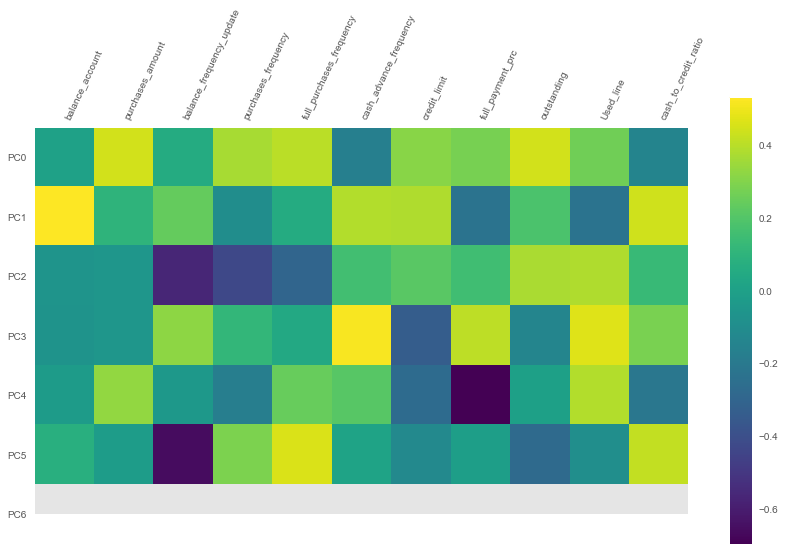

In [49]:
# looped, clean version

plt.matshow(pca.components_, cmap="viridis")
plt.yticks(range(7), [f"PC{k}" for k in range(8)], fontsize=10)
plt.colorbar()
plt.grid(False)
plt.xticks(range(len(to_keep)), to_keep, rotation=65, ha="left")
plt.tight_layout()
plt.show()  #

### Vanilla K Means clustering

In [50]:
pipe_kmean = Pipeline([("scl", StandardScaler()), ("kmean", KMeans(n_clusters=5))])

In [51]:
pipe_kmean.fit(data_filtered)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kmean',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=5, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

We can check the cluster centers of each cluster. The center of the cluster is the average of all data points (elements) that belongs to that cluster - so we can have an idea of what brought all the elements in a cluster together.

In [52]:
km_data = pd.DataFrame(
    pipe_kmean.named_steps["kmean"].cluster_centers_, columns=data_filtered.columns
)
km_data

balance_account  purchases_amount  balance_frequency_update  \
0        -0.677771         -0.301856                 -2.038172   
1        -0.027245         -0.374114                  0.386486   
2         1.898159         -0.202216                  0.439817   
3         0.243041          1.448099                  0.373643   
4        -0.388117         -0.001257                  0.365157   

   purchases_frequency  full_purchases_frequency  cash_advance_frequency  \
0            -0.529581                 -0.456924               -0.442597   
1            -0.869350                 -0.454938                0.266334   
2            -0.439596                 -0.232593                1.628720   
3             1.030864                  1.740109               -0.351059   
4             0.879933                  0.049715               -0.463886   

   credit_limit  full_payment_prc  outstanding  Used_line  \
0     -0.258092          0.252503     0.014775   0.569080   
1     -0.399573         -0.463587    -0.452963  -0.426208   
2      1.099437         -0.486507     0.257665  -0.611006   
3      1.243806          0.593625     1.430043   0.452341   
4     -0.371058          0.258875    -0.241925   0.158267   

   cash_to_credit_ratio  
0             -0.343029  
1             -0.042566  
2              2.071958  
3             -0.302075  
4             -0.379757

Assigning a label to each cluster will be useful in the analysis:

In [53]:
data_filtered_km = data_filtered.assign(
    km_cluster=pipe_kmean.named_steps["kmean"].labels_
)
data_filtered_km.head()

balance_account  purchases_amount  balance_frequency_update  \
0         9.298409            107.60                  0.909091   
1        52.666422            150.30                  1.000000   
2      1360.795674              0.00                  1.000000   
3      2021.641161            363.18                  1.000000   
4        22.322374             95.00                  0.363636   

   purchases_frequency  full_purchases_frequency  cash_advance_frequency  \
0             0.909091                  0.000000                0.000000   
1             1.000000                  0.000000                0.000000   
2             0.000000                  0.000000                0.272727   
3             1.000000                  1.000000                0.000000   
4             0.083333                  0.083333                0.166667   

   credit_limit  full_payment_prc  outstanding  Used_line  \
0        1000.0          0.428571  1080.570444   1.080570   
1        1000.0          0.000000  1002.056092   1.002056   
2        1500.0          0.000000   442.236305   0.294824   
3        2000.0          0.000000   682.599609   0.341300   
4        2500.0          0.000000  6571.939053   2.628776   

   cash_to_credit_ratio  km_cluster  
0              0.000000           4  
1              0.000000           4  
2           1569.957411           1  
3              0.000000           4  
4            442.048315           0

### K Means clustering with PCA

In [54]:
pipe_pca_kmean = Pipeline([("scl", StandardScaler()), ("kmean", KMeans(5))])

In [55]:
pipe_pca_kmean.fit(data_pca)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kmean',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=5, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [56]:
kmean_pca_data = pd.DataFrame(pipe_pca_kmean.named_steps["kmean"].cluster_centers_)

In [57]:
kmean_pca_data.columns = ["pca" + str(i) for i in kmean_pca_data.columns]

In [58]:
kmean_pca_data

pca0      pca1      pca2      pca3      pca4      pca5
0  0.845501 -0.832507  0.172862  0.753738 -1.668837 -0.058805
1 -0.445251 -0.062749 -0.265392 -0.109724  0.181768 -0.623656
2 -0.543092  1.981682  0.418273  0.733534 -0.394452  0.566036
3  1.161594  0.245919 -0.809498 -0.091101  0.791698  0.574238
4 -0.295175 -0.799303  1.408791 -0.849630  0.404302  1.087448

We take data_filtered dataframe (created before, and having labels from K-means without PCA in km_cluster column) and create a new column for labels produced after applying PCA + K-means

In [59]:
data_filtered_km = data_filtered_km.assign(
    km_cluster_pca=pipe_pca_kmean.named_steps["kmean"].labels_
)
data_filtered_km.head()

balance_account  purchases_amount  balance_frequency_update  \
0         9.298409            107.60                  0.909091   
1        52.666422            150.30                  1.000000   
2      1360.795674              0.00                  1.000000   
3      2021.641161            363.18                  1.000000   
4        22.322374             95.00                  0.363636   

   purchases_frequency  full_purchases_frequency  cash_advance_frequency  \
0             0.909091                  0.000000                0.000000   
1             1.000000                  0.000000                0.000000   
2             0.000000                  0.000000                0.272727   
3             1.000000                  1.000000                0.000000   
4             0.083333                  0.083333                0.166667   

   credit_limit  full_payment_prc  outstanding  Used_line  \
0        1000.0          0.428571  1080.570444   1.080570   
1        1000.0          0.000000  1002.056092   1.002056   
2        1500.0          0.000000   442.236305   0.294824   
3        2000.0          0.000000   682.599609   0.341300   
4        2500.0          0.000000  6571.939053   2.628776   

   cash_to_credit_ratio  km_cluster  km_cluster_pca  
0              0.000000           4               0  
1              0.000000           4               1  
2           1569.957411           1               1  
3              0.000000           4               3  
4            442.048315           0               4

#### Matching vanilla vs pca kmeans clusters

In [60]:
vanilla2pca = (
    data_filtered_km[["km_cluster", "km_cluster_pca"]]
    .groupby("km_cluster")
    .apply(lambda x: x["km_cluster_pca"].value_counts().index[0])
)
vanilla2pca

km_cluster
0    4
1    1
2    2
3    3
4    1
dtype: int64

### T-Sne

In [99]:
tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=1000, n_jobs=-1)
data_tsne = tsne.fit_transform(data_filtered)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8497 samples in 0.051s...
[t-SNE] Computed neighbors for 8497 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8497
[t-SNE] Computed conditional probabilities for sample 2000 / 8497
[t-SNE] Computed conditional probabilities for sample 3000 / 8497
[t-SNE] Computed conditional probabilities for sample 4000 / 8497
[t-SNE] Computed conditional probabilities for sample 5000 / 8497
[t-SNE] Computed conditional probabilities for sample 6000 / 8497
[t-SNE] Computed conditional probabilities for sample 7000 / 8497
[t-SNE] Computed conditional probabilities for sample 8000 / 8497
[t-SNE] Computed conditional probabilities for sample 8497 / 8497
[t-SNE] Mean sigma: 47.255929
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.878426
[t-SNE] KL divergence after 1000 iterations: 0.886026


In [100]:
data_tsne.shape

(8497, 3)

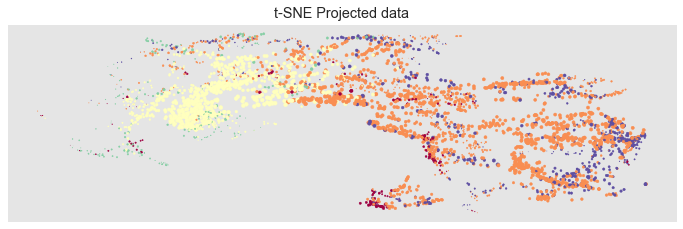

In [101]:
fig = plt.figure()

# plot projected data
ax = fig.add_subplot(212)
ax.scatter(
    data_tsne[:, 0],
    data_tsne[:, 1],
    data_tsne[:, 2],
    c=data_filtered_km["km_cluster"],
    cmap=plt.cm.Spectral,
)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("t-SNE Projected data")
plt.show()


plt.show()

In [102]:
fig = px.scatter_3d(data_tsne, x=data_tsne[:, 0], y= data_tsne[:, 1], z=data_tsne[:, 2], color=data_filtered_km["km_cluster"]) 

fig.show()

### UMAP

In [105]:
umap_embeddings = umap.UMAP(n_neighbors=30, n_components=3, min_dist=0.3)

In [110]:
data_umap = umap_embeddings.fit_transform(data_filtered)

In [ ]:
fig = px.scatter_3d(data_tsne, x=data_umap[:, 0], y= data_umap[:, 1], z=data_umap[:, 2], color=data_filtered_km["km_cluster"]) 

fig.show()

### Compare other clustering methods

### Hierarchical Clustering 

One of the disatvantages of K means clustering is that it requires to specify th enumber of clusters beforehand. Hierarchical clustering is an alternative and has the advantage also of the tree based representation of observations: dendogram

In [ ]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_= AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=5).fit_predict(data_filtered)

clustering = AgglomerativeClustering().fit(data_filtered)
clustering

clustering.labels_

data['hierarchy_clusters'] = hierarchical_ 

In [ ]:
data['hierarchy_clusters'].value_counts()


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(15,10)) 
plt.title("Dendrogram with Linkage Method: Average") 
plt.xlabel('Sample Index or Cluster Size') 
plt.ylabel('Distance') 
          

dendrogram(linkage(data, method='average')) 
plt.show() 

In [ ]:
data_group = data[to_keep + ["hierarchy_clusters"]].groupby("hierarchy_clusters").mean()

fig, ax = plt.subplots(len(to_keep), 1, figsize=(15, 25))
plt.subplots_adjust(wspace=0.7, hspace=1.3)
for icat, cat in enumerate(to_keep):
    data_group[cat].plot.barh(ax=ax[icat], color=sns.color_palette("colorblind", 5))
    ax[icat].set_title(cat)

### Outlier Detection

In [ ]:
# Workflow reference:

kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
kmeans_pca = KMeans(n_clusters=4, random_state=42).fit(X_pca)
kmeans_tsne = KMeans(n_clusters=4, random_state=42).fit(X_tsne)
kmeans_umap = KMeans(n_clusters=4, random_state=0).fit(X_umap)